# TUTORIAL 2: Conditional GAN
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed **Pytorch** and **Augmentare** properly.

This tutorial uses the highly popular Conditional GAN or **CGAN** architecture. **Augmentare** provides a generalised implementation of **CGAN**.

**Paper** - [Conditional Generative Adversarial Nets by Mehdi Mirza & Simon Osindero.](https://arxiv.org/abs/1411.1784)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import numpy as np

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.gan import *
from augmentare.plots.plot_losses import plot_losses_gan
from augmentare.plots.plot_samples import plot_image

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wgfbn8qe because the default path (/home/vuong.nguyen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING
This tutorial uses the **MNIST** dataset for illustration purposes. We apply the following transformations to the raw dataset to speed up training:

1. MNIST digits have a size of $28 \times 28$ by default. For the purposes of this tutorial, we resize the images to $32 \times 32$.

2. The images are normalized with a mean and standard deviation of 0.5 for each channel. This has been observed to enable easier training (one can also choose to normalize with the per channel mean and standard deviation).

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
image_size = 32
dataset = dsets.MNIST('/home/vuong.nguyen/vuong/data-augmentation-fairness/data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,),(0.5,))
                    ]))

dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)

/home/vuong.nguyen/vuong/augmentare/vuong_dev_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


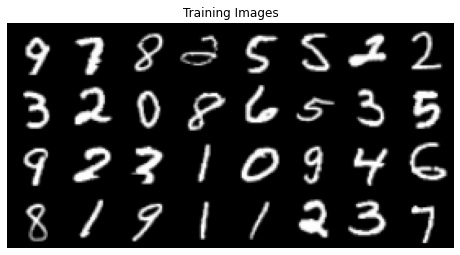

In [5]:
#Plot some training images 
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## NETWORK ARCHITECTURE : CGAN 

### GENERATOR NETWORK
The CGAN Generator is parameterized to learn and produce realistic samples for each label in the training dataset. It receives an input noise vector of size $batch\ size \times latent\ size$. It outputs a tensor of $batch\ size \times channel \times height \times width$ corresponding to a batch of generated image samples.

The intermediate layers use the **LeakyReLU** activation function to kill gradients and slow down convergence. We can also use any other activation to ensure a good gradation flow. The last layer uses the **Tanh** activation to constrain the pixel values ​​to the range of $(- 1 \to 1)$. 

### DISCRIMINATOR NETWORK
The CGAN Discriminator learns to distinguish fake and real samples, given the label information. It has a symmetric architecture to the generator. It maps the image with a confidence score to classify whether the image is real (i.e. comes from the dataset) or fake (i.e. sampled by the generator) 

We use the **LeakyReLU** activation for Discriminator. We also use **Dropout** activation, it's an effective technique for regularization and preventing the co-adaptation of neurons.

The last layer of CGAN's Discriminator has a **Sigmoid** layer that makes the confidence score between $(0 \to 1)$ and allows the confidence score to be easily interpreted in terms of the probability that the image is real. However, this interpretation is restricted only to the Minimax Loss proposed in the original GAN paper, and losses such as the Wasserstein Loss require no such interpretation. However, if required, one can easily set last layer activation to **Sigmoid** by passing it as a parameter during initialization time.

#### CGAN Generator

A generator is parameterized to learn and produce realistic samples for each label in the training dataset.

Hyperparameters:

`latent_size:` Size of latent vector (i.e. size of generator input)

`num_classes:` Number of classes in dataset, more than 0 for Conditional GANs

`image_shape:` Shape of image (C, H, W)

In [7]:
images, labels = next(iter(dataloader))
image_shape = images[0].shape

net_gen = CGANGenerator(
    latent_size=100,
    num_classes=10,
    image_shape=image_shape
)

#### CGAN Discriminator

A discriminator learns to distinguish fake and real samples, given the label information. Output activation is Sigmoid.

Hyperparameters:

`num_classes:` Number of classes in dataset, more than 0 for Conditional GANs

`image_shape:` Shape of image (C, H, W)

In [8]:
net_dis = CGANDiscriminator(
    num_classes=10,
    image_shape=image_shape
)

## OPTIMIZERS AND LOSS FUNCTIONS

This tutorial for the example about **CGAN** optimized by the Adam optimizer and used a function loss is **BCELoss**.

#### Other Parameters (optimizer, loss function)

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=0.0001$

-`Beta1:` Exponential decay rate for the first time estimate.

-`Beta2:` Exponentially decay rate for second time estimates. This value should be set close to $1.0$ for problems with sparse gradients (e.g. NLP and computer vision problems).

We use this **BCELoss** function in the case where the final output from the network is a single value (the last dense layer of size 1) is between 0 and 1. 


In [9]:
optimizer_gen = Adam(net_gen.parameters(), lr=0.0001)
optimizer_dis = Adam(net_dis.parameters(), lr=0.0001)
loss_fn_gen =  nn.BCELoss()
loss_fn_dis =  nn.BCELoss()

#### Create your GAN object

A basic CGAN class for generating images with the condition.

Parameters:

`generator:` A torch CGAN Generator architecture

`discriminator:` A torch CGAN Discriminator architecture

`optimizer_gen:` An optimizer for generator

`optimizer_dis:` An optimizer for discriminator

`loss_fn_gen:` A loss function for generator

`loss_fn_dis:` A loss function for discriminator

`device:` Cpu or CUDA

`latent_size:` Size of latent vector (i.e size of generator input)

In [10]:
# Create GAN network
gan = CGAN(
    net_gen,
    net_dis,
    optimizer_gen,
    optimizer_dis,
    loss_fn_gen,
    loss_fn_dis,
    device,
    latent_size=100,
    init_weights=False
)

## TRAINING THE CGAN NETWORK

Training the model is quite expensive. Hence, we will train models for 20 epochs if GPU is available, otherwise we will train only for 10 epochs. We should change **num_epochs** so that the model learns to generate good quality images.

Train both generator and discriminator and return the losses.

Parameters:

`subset_a:` Torch.tensor or Dataset

`num_epochs:` The number of epochs you want to train your GAN

`num_decay_epochs:` The number of epochs to start linearly decaying the learning rate to 0 (optional)

`num_classes:` Number of classes in dataset (optional)

`batch_size:` Training batch size (optional)

`subset_b:` The second Torch.tensor or Dataset (optional)

Returns:

`gen_losses, dis_losses:` The losses of both the discriminator and generator

In [11]:
gen_losses, dis_losses = gan.train(
    subset_a=dataloader,
    num_epochs=20,
    num_decay_epochs = None,
    num_classes=10,
    batch_size=32,
    subset_b = None
)

[1/20][0/1875]                             	Loss_D: 1.377305030822754 	Loss_G: 0.6793643832206726
[1/20][50/1875]                             	Loss_D: 0.6236399412155151 	Loss_G: 0.84015291929245
[1/20][100/1875]                             	Loss_D: 0.43222078680992126 	Loss_G: 1.638120412826538
[1/20][150/1875]                             	Loss_D: 0.2089238166809082 	Loss_G: 3.4367265701293945
[1/20][200/1875]                             	Loss_D: 0.10625208169221878 	Loss_G: 4.540619850158691
[1/20][250/1875]                             	Loss_D: 0.04569951072335243 	Loss_G: 3.6074936389923096
[1/20][300/1875]                             	Loss_D: 0.13185523450374603 	Loss_G: 3.54628849029541
[1/20][350/1875]                             	Loss_D: 2.132754325866699 	Loss_G: 1.3168821334838867
[1/20][400/1875]                             	Loss_D: 1.6541997194290161 	Loss_G: 2.781174898147583
[1/20][450/1875]                             	Loss_D: 0.7781058549880981 	Loss_G: 4.400199413299560

#### Plots the Losses

Plots losses for generator and discriminator on a common plot.

Parameters:

`gen_losses:` A list of generator losses
    
`dis_losses:` A list of discriminator losses

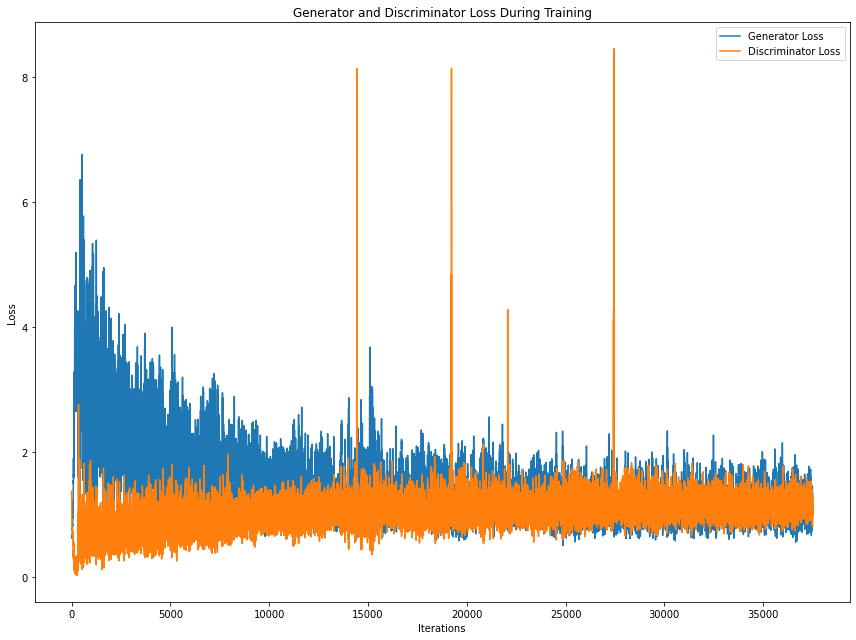

In [12]:
plot_losses_gan(gen_losses,dis_losses)

## VISUALIZE THE GENERATED DATA

#### Sample images from the generator.

Parameters:

`nb_samples:` The number of samples to generate

`num_classes:` Number of classes in dataset

`real_image_a:` Real image in subset_a (optional)

`real_image_b:` Real image in subset_b (optional)

Returns:

`img_list:` A list of generated images (one image of one class is successively a list)

In [13]:
img_list = gan.generate_samples(
    nb_samples=32,
    num_classes=8,
    real_image_a = None,
    real_image_b = None
)

#### Plots images

Plot a number of generated images with optional label

Parameters:

`img_list:` A list of generated images (Torch tensor)

`number:` Number of images we want to plot

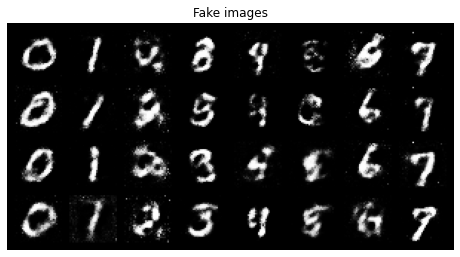

In [14]:
plot_image(img_list, number=32)